In [4]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import json
from pandas.io.json import json_normalize
from IPython.display import display
from pandas import HDFStore,DataFrame
import pandas as pd

%matplotlib inline 

<h2>Prepare inputs for ML</h2>
<h4>CMS model </h4>
- Inputs: X = name (DSID, scope, ...), panda jobs, replica used , users up to week X-1 (6 months)<br> 
- Output: Y = signal (used in week X)/background (not used in week X)<br>
- Predictions are made for week X+1
<br><br>

- add all data for popularity measurement: sum up over panda ids, replicas, users
- add data for prediction: use datasets not used in that week (add randomly to have 10x background than signal)

[arXiv:1602.07226]

<h3>First, open files</h3>


In [5]:
#Open weekly summaries and returns a dictionary of dataframes, key is date
def openFiles(start, end):
    
    dt = start
    dataFrames = {}
    step = datetime.timedelta(days=7)
    
    #loop over all results
    while dt < end:
    
        filename = 'DataPopularity_data/weekly_'+str(dt)+'.h5'
        df = pd.read_hdf(filename, 'result')       
        dataFrames[dt]=df
        dt += step     
        #print('Opening '+filename)
    #print(dataFrames)
    return dataFrames

In [6]:
#open files and create dictionary of DataFrames, key is date
start = datetime.date(2016, 1, 1)                # measurement: starting date
ndays = 520                                       # Total range of input data
end = start + datetime.timedelta(days=ndays)      # end measurement

dataFrames = openFiles(start, start+ datetime.timedelta(days=int(ndays)) )
print(len(dataFrames))

75


<h3>Create dataframe with weekly summaries</h3>

In [7]:
# function to merge datasets with same name and different tids (datasets -> container)
def mergeTID(df):

    df['name'], df['tid'] = df['name'].str.split('_tid', 1).str
    #display(df.shape)
    df = df.groupby(['name','type','scope']).agg({"pandaid": np.sum, "user": np.sum,  "site": np.sum}).reset_index()
    #display(df.shape)
    
    return df

In [8]:
#loop over weekly dataframes and aggregate them

start = datetime.date(2016, 1, 1)              # measurement: starting date
end = start + datetime.timedelta(weeks=2)      # end measurement

#loop over all results, and create a list of dataframes with weekly summaries
nWeek = 0
dfs_weekly = []

dt = start
merged = dataFrames[dt]
merged = merged.drop(['user','site','taskid','cputime', 'walltime', 'size', 'nevents', 'nfiles'], 1)
dt += datetime.timedelta(days=7)

while dt < end:
    print(str(dt), end=" ")
    dt += datetime.timedelta(days=7)
    df = dataFrames[dt]     
#    df = df.drop(['date'], axis=1)

    #week starts
#   if ((dt.weekday() == start.weekday())): #start with first dataframe 
         
#        df_week = df
#        nWeek += 1
#        print('Adding week '+str(nWeek))
#        weekEnd = dt + datetime.timedelta(days=7)
        
#        #loop over the week, add dataframes
#        while dt < weekEnd:
#            #print(str(dt))

#            df = dataFrames[dt]     
#            df = df.drop(['date'], axis=1)
            
#            df_week = pd.concat([df, df_week]).groupby(['name','type','scope']).agg({"pandaid": np.sum, "user": np.sum,  "site": np.sum}).reset_index()
            
#            #week ends
#            if dt == weekEnd:
#                #print('Saving df')                
#                #merge tids datasets
#                df_week = mergeTID(df_week)                
#                df_week = df_week.rename(index=str, columns={"pandaid":"pandaid_week"+str(nWeek), 
#                                                             "user":"user_week"+str(nWeek),
#                                                             "site":"site_week"+str(nWeek),})
#                dfs_weekly.append(df_week)   
    df = df.drop(['user','site','taskid','cputime', 'walltime', 'size', 'nevents', 'nfiles'], 1)
    merged = merged.merge(df, how='outer', on=['name', 'scope'])

display(df.head(5))
display(merged.head(10))
#merge weekly dataframes                                 
#merged = dfs_weekly[0]
list(merged)
#for df in dfs_weekly[1:]:
#    merged = merged.merge(df, how='outer', on=['name', 'type', 'scope'])

2016-01-08 

,name,scope,pandaid
0,data11_7TeV.00178044.physics_Muons.merge.DAOD_...,data11_7TeV,2
1,data11_7TeV.00178047.physics_Muons.merge.DAOD_...,data11_7TeV,1
2,data11_7TeV.00178109.physics_Muons.merge.DAOD_...,data11_7TeV,4
3,data11_7TeV.00179710.physics_Muons.merge.DAOD_...,data11_7TeV,3
4,data11_7TeV.00179725.physics_Muons.merge.DAOD_...,data11_7TeV,1


,name,scope,pandaid_x,pandaid_y
0,data12_8TeV.00202712.physics_Bphysics.merge.DA...,data12_8TeV,11.0,NaN
1,data12_8TeV.00202740.physics_Bphysics.merge.DA...,data12_8TeV,1.0,NaN
2,data12_8TeV.00202798.physics_Bphysics.merge.DA...,data12_8TeV,2.0,NaN
3,data12_8TeV.00202965.physics_Bphysics.merge.DA...,data12_8TeV,1.0,NaN
4,data12_8TeV.00202987.physics_Bphysics.merge.DA...,data12_8TeV,1.0,NaN
5,data12_8TeV.00202991.physics_Bphysics.merge.DA...,data12_8TeV,2.0,NaN
6,data12_8TeV.00203027.physics_Bphysics.merge.DA...,data12_8TeV,3.0,NaN
7,data12_8TeV.00203169.physics_Bphysics.merge.DA...,data12_8TeV,1.0,NaN
8,data12_8TeV.00203191.physics_Bphysics.merge.DA...,data12_8TeV,1.0,NaN
9,data12_8TeV.00203195.physics_Bphysics.merge.DA...,data12_8TeV,2.0,NaN


['name', 'scope', 'pandaid_x', 'pandaid_y']

<h3>Manipulate dataframe</h3>

In [9]:
# get ptag from dataset name
def getPtag(name):

    sub = name.split('.')
    #print(sub)
    last = len(sub)
    tags = sub[last-1]
    #print(tags)
    ptag=''
    subtags = tags.split('_')
    #print(subtags)
    for i in subtags:
        if (i.startswith('p')): # takes always the last one
            ptag = i
    return(ptag)      

In [10]:
# get DSID from dataset name
def getDSID(name):

    sub = name.split('.')
    #print(sub)

    dsid = sub[1]
    
    #remove 00 for data
    if (dsid.startswith('00')):
        dsid  = dsid[2:]
    #print(dsid)
    return(dsid)  

<h3>We end up with a dataframe with dataset name, type, scope, dsid, ptag, accesses in total and for unique user or replica per day binned on a weekly basis</h3>

In [11]:
merged = merged.fillna(0)

merged['dsid'] = merged['name'].apply(getDSID)
merged['ptag'] = merged['name'].apply(getPtag)
    
#display(merged.memory_usage())    
display(merged.head(5))  
display(merged.shape)

,name,scope,pandaid_x,pandaid_y,dsid,ptag
0,data12_8TeV.00202712.physics_Bphysics.merge.DA...,data12_8TeV,11.0,0.0,202712,p1425
1,data12_8TeV.00202740.physics_Bphysics.merge.DA...,data12_8TeV,1.0,0.0,202740,p1425
2,data12_8TeV.00202798.physics_Bphysics.merge.DA...,data12_8TeV,2.0,0.0,202798,p1425
3,data12_8TeV.00202965.physics_Bphysics.merge.DA...,data12_8TeV,1.0,0.0,202965,p1425
4,data12_8TeV.00202987.physics_Bphysics.merge.DA...,data12_8TeV,1.0,0.0,202987,p1425


(21763, 6)

<h3>Check Memory consumption</h3>

In [12]:
def GetHumanReadable(size,precision=2):
    suffixes=['B','KB','MB','GB','TB']
    suffixIndex = 0
    while size > 1024 and suffixIndex < 4:
        suffixIndex += 1 #increment the index of the suffix
        size = size/1024.0 #apply the division
    return "%.*f%s"%(precision,size,suffixes[suffixIndex])

In [13]:
GetHumanReadable(merged.memory_usage(index=True, deep=True).sum())

'8.07MB'

<h3>Create dataframes for 6 months (26 weeks, 26th week is X-1)</h3>
<h3>Signal/background is number of accesses in week X</h3>

In [75]:
# get positive numbers
def isPositive(number):
    if (number>0):
        return 1
    else:
        return 0

In [93]:
#sum up all weeks up to X-1, get signal/background (Y) for week X
def sumUp(df, X):

    metrics = ['user', 'pandaid', 'site']    
    df_new =  df.filter(items=['type', 'scope', 'dsid', 'ptag'])
    
    #get Y
    df_new['Y'] = df[metrics[0]+'_week'+str(X)].apply(isPositive)    
    
    #get X
    for metric in metrics:
        
        #sum up until week X-1
        for i in range(X-26, X): # use 6 months for training

            if i == (X-26): #first week             
                df_new[metric] = df[metric+'_week'+str(i)]
            else:      
                df_new[metric] += df[metric+'_week'+str(i)]                  
            
    return df_new 

In [95]:
#merged = merged.drop('user', 1)
#merged = merged.drop('Y', 1)
df = sumUp(merged, 27)
merged.head()
df.head()

,type,scope,dsid,ptag,Y,user,pandaid,site
0,DAOD_JPSIMUMU,data12_8TeV,202712,p1425,1,17.0,569.0,17.0
1,DAOD_UPSIMUMU,data12_8TeV,202712,p1425,0,5.0,30.0,5.0
2,DAOD_JPSIMUMU,data12_8TeV,202740,p1425,0,19.0,138.0,19.0
3,DAOD_UPSIMUMU,data12_8TeV,202740,p1425,0,5.0,10.0,5.0
4,DAOD_JPSIMUMU,data12_8TeV,202798,p1425,0,21.0,988.0,19.0


In [101]:
def toML(df, X):    

    #get summed up dataframe
    df_new = sumUp(df, X) 
    #display(df.head(5))  
    #display(df.shape)
    
    #rescale numerical inputs
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler() 

    df_new['pandaid'] = scaler.fit_transform(df_new['pandaid'].astype(float).values.reshape(-1, 1)) 
    df_new['site'] = scaler.fit_transform(df_new['site'].astype(float).values.reshape(-1, 1)) 
    df_new['user'] = scaler.fit_transform(df_new['user'].astype(float).values.reshape(-1, 1)) 

    #convert categorical to numerical
    df_with_dummies = pd.get_dummies(df_new, columns = ['type', 'scope', 'ptag'], sparse = True )
    #df_with_dummies = pd.get_dummies(df_with_dummies, columns = ['dsid'] , sparse = True)

    df_X = df_with_dummies.drop(['dsid', 'Y'], axis=1)
    df_Y = df_with_dummies['Y']

    #display(df_X.head(5))  
    #display(df_X.shape)
    #display(GetHumanReadable(df_X.memory_usage(index=True, deep=True).sum()))    
    
    #finally, store to file
    store = HDFStore('DataPopularity_ML/CMSModel_week'+str(X)+'.h5')
    store['X'] = df_X
    store['Y'] = df_Y
    store.close()
    
    return

In [122]:
def toMLBinned(df, X):    

    metrics = ['user', 'pandaid', 'site']
    df_new =  df.filter(items=['type', 'scope', 'dsid', 'ptag'])
    
    #get Y
    df_new['Y'] = df[metrics[0]+'_week'+str(X)].apply(isPositive)  
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()   
    
    #get X
    for metric in metrics:
        
        # use for inputs until week X-1
        for i in range(X-26, X): # use 6 months for training
            
            #offset to have always same week numbers
            offset = i+1 - (X - 26)
            
            #rescale numerical inputs  
            df_new[metric+'_week'+str(offset)] = scaler.fit_transform(df[metric+'_week'+str(i)].astype(float).values.reshape(-1, 1))     
            
    #display(df_new.head(5))  
    #display(df_new.shape)    

    #convert categorical to numerical
    df_with_dummies = pd.get_dummies(df_new, columns = ['type', 'scope', 'ptag'], sparse = True )
    #df_with_dummies = pd.get_dummies(df_with_dummies, columns = ['dsid'] , sparse = True)

    df_X = df_with_dummies.drop(['dsid', 'Y'], axis=1)
    df_Y = df_with_dummies['Y']

    #display(df_X.head(5))  
    #display(df_X.shape)
    #display(GetHumanReadable(df_X.memory_usage(index=True, deep=True).sum()))    
    
    #finally, store to file
    store = HDFStore('DataPopularity_ML/BinnedModel_week'+str(X)+'.h5')
    store['X'] = df_X
    store['Y'] = df_Y
    store.close()
    
    return

## Automatization

create ML-ready inputs starting from date and defining time for measurement of popularity and test

In [117]:
#use at least 6 months for training for CMS model
for X in range(27, 52): 
    print('Processing week '+str(X))
    toML(merged, X) # X week used for signal/background (Y), weeks up to X-1 are used to get Xs   

Processing week 27


In [123]:
#Binned model
for X in range(27, 52): 
    print('Processing week '+str(X))
    toMLBinned(merged, X) # X week used for signal/background (Y), weeks up to X-1 are used to get Xs   

Processing week 27
Processing week 28
Processing week 29
Processing week 30
Processing week 31
Processing week 32
Processing week 33
Processing week 34
Processing week 35
Processing week 36
Processing week 37
Processing week 38
Processing week 39
Processing week 40
Processing week 41
Processing week 42
Processing week 43
Processing week 44
Processing week 45
Processing week 46
Processing week 47
Processing week 48
Processing week 49
Processing week 50
Processing week 51


In [19]:
#make categories of dsids?

ts = merged.sort_values(by='dsid')
ts = ts['dsid'].drop_duplicates()
display(ts)

99980     110101
91016     110910
94903     110916
34972     117050
34975     119995
194383    147806
194384    147807
150860    147808
71622     159000
21889     167749
21890     167750
21891     167751
99982     167752
21893     167753
21894     167755
21895     167756
96429     167761
75556     167762
75557     167763
96430     167764
75559     167765
192741    167766
92511     167767
75562     167768
75563     167769
75564     167770
75565     167771
75566     167772
92513     167773
150863    167774
           ...  
116998    426134
89252     426135
99959     426136
99960     426137
77999     426138
197648    426139
117010    426140
160296    426141
47261     426142
81487     427000
47263     427030
78009     427031
39196     427032
39197     427033
78015     427034
103515    427080
34992     428000
35005     428001
35012     428002
59289     429007
19035     429400
19036     429401
19037     429402
19038     429404
19039     429405
19040     429406
19041     429407
19042     4294

<h3>Look at the data: make a few histograms</h3>
number of accesses per type/scope/ptag

In [221]:
def createHistos(df, groupby, metric, nmax):
    
    #reduce by scope/type/ptag, for one metric (user, pandaid, site)
    
    #create aggregation on different columns (use ordered dictionary to preserve columns order)
    from collections import OrderedDict
    agg_d = OrderedDict() #= {}   
    
    nweeks = df.filter(like=metric,axis=1).shape[1]
    
    for i in range(1, nweeks+1):     
        agg_d[metric+"_week"+str(i)] = np.sum

    df = df.groupby(groupby).agg(agg_d).reset_index()

    #display(df.head(5))
    #display(df.shape)
   
    array = df.select_dtypes(exclude=['object']).apply(lambda x: x.tolist(), axis=1).as_matrix()
    
    #select the rows with largest sum
    sums = np.sum(array, 1)    
    idx = (-sums).argsort()[:nmax]
    
    plt.figure(figsize=(20,10))
    for i in idx: 
        s = array[i]
        hist = plt.bar(np.arange(len(s)),s, label = df[groupby][i] )
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
    plt.show()
        
    return

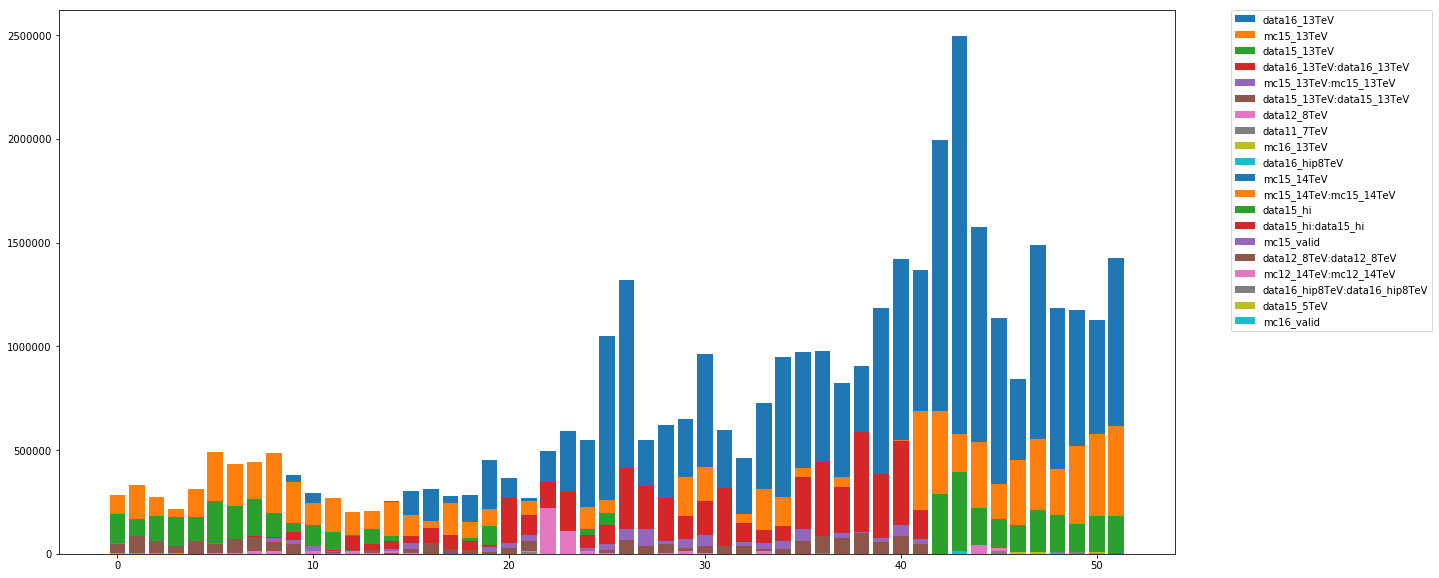

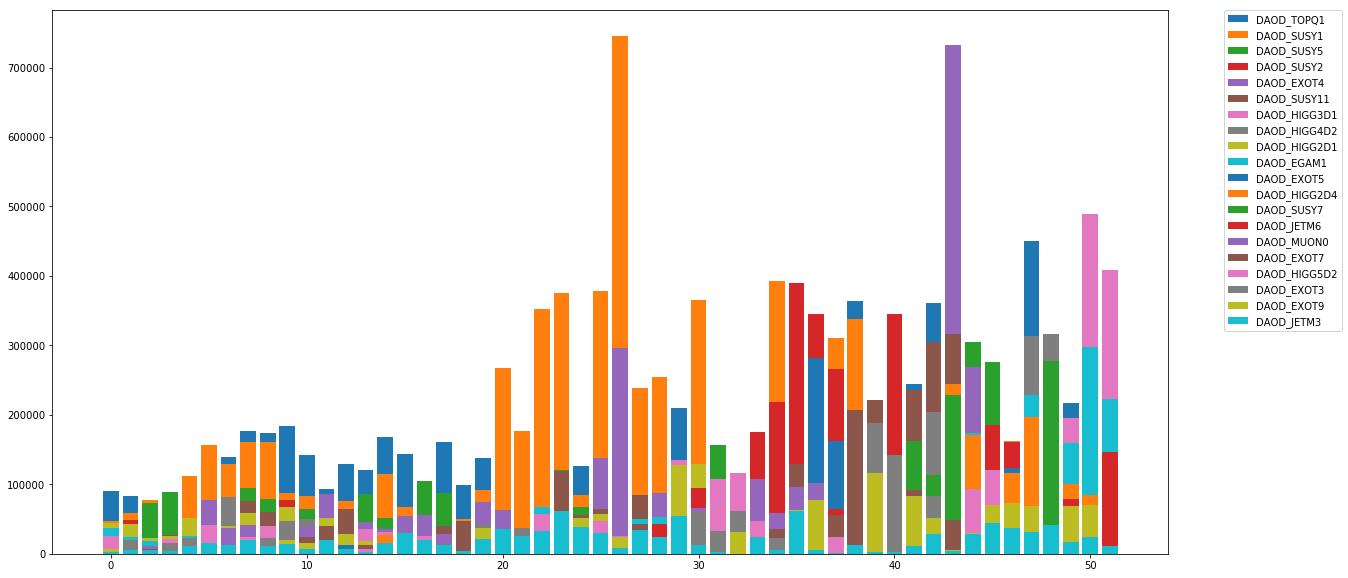

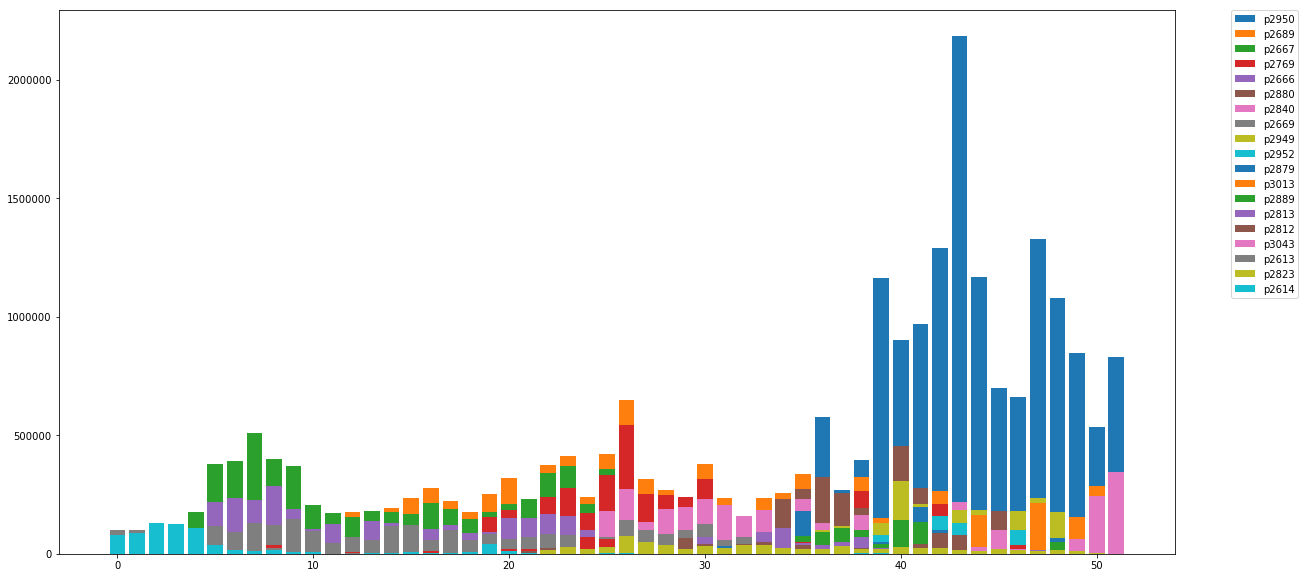

In [226]:
createHistos(merged, 'scope', 'pandaid', 20)
createHistos(merged, 'type', 'pandaid', 20)
createHistos(merged, 'ptag', 'pandaid', 20)

<h3>Correlations between inputs</h3>
To reduce number of columns, make monthly summaries, and use LabelEncoder instead of Bag of Words for text columns

In [274]:
#using labelEncoder for text -> not very useful since order matters in ML but can be used to get correlations plots

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_enc = merged.copy()
df_enc['type_enc'] = label_encoder.fit_transform(df_enc['type'])
df_enc['scope_enc'] = label_encoder.fit_transform(df_enc['scope'])
df_enc['dsid_enc'] = label_encoder.fit_transform(df_enc['dsid'])
df_enc['ptag_enc'] = label_encoder.fit_transform(df_enc['ptag'])

df_enc = df_enc.drop(['name', 'type', 'scope', 'dsid', 'ptag'], axis=1)

display(df_enc.head(5))
df_enc.shape

,pandaid_week1,site_week1,user_week1,pandaid_week2,site_week2,user_week2,pandaid_week3,site_week3,user_week3,pandaid_week4,...,pandaid_week51,site_week51,user_week51,pandaid_week52,site_week52,user_week52,type_enc,scope_enc,dsid_enc,ptag_enc
0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80,2,344,2
1,12.0,2.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,127,2,344,2
2,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80,2,345,2
3,4.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,127,2,345,2
4,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80,2,346,2


(204760, 160)

In [275]:
#create dataframes with monthly summaries for weekly metrics
def getMonthly(df, metrics):

    for metric in metrics:
        nweeks = df.filter(like=metric+'_week',axis=1).shape[1]    
        month = 0
        weekinMonth = 4
        #print(str(nweeks))
        for i in range(1, nweeks+1):

            if weekinMonth < 4:             
                weekinMonth += 1
                #print('Adding week '+str(i))
                df[metric+'_month'+str(month)] += df[metric+'_week'+str(i)]

            elif weekinMonth == 4:
                month += 1
                weekinMonth = 1
                #print('Starting new month '+str(month)+' with week '+str(i))        
                df[metric+'_month'+str(month)] = df[metric+'_week'+str(i)]      
            
            df = df.drop(metric+'_week'+str(i), axis=1) #drop after adding
              
    return df 

In [286]:
metrics = ['user', 'pandaid', 'site']
XY = getMonthly(df_enc, metrics)
display(XY.head(5))
XY.shape

,type_enc,scope_enc,dsid_enc,ptag_enc,user_month1,user_month2,user_month3,user_month4,user_month5,user_month6,...,site_month4,site_month5,site_month6,site_month7,site_month8,site_month9,site_month10,site_month11,site_month12,site_month13
0,80,2,344,2,1.0,2.0,2.0,5.0,0.0,4.0,...,5.0,0.0,4.0,7.0,1.0,1.0,0.0,0.0,7.0,0.0
1,127,2,344,2,3.0,0.0,0.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,80,2,345,2,1.0,2.0,2.0,5.0,0.0,5.0,...,5.0,0.0,5.0,4.0,1.0,1.0,0.0,0.0,6.0,0.0
3,127,2,345,2,3.0,0.0,0.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,80,2,346,2,1.0,2.0,2.0,5.0,0.0,6.0,...,5.0,0.0,4.0,5.0,1.0,1.0,0.0,0.0,8.0,0.0


(204760, 43)

In [301]:
def correlations(data, title = '', **kwds):
    """Calculate pairwise correlation between features.    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of correlation values if you do not need the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(7,6))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Correlations "+title)

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()

(171182, 19)

(33578, 19)

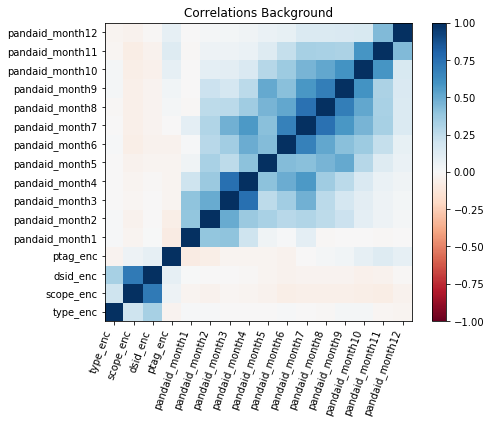

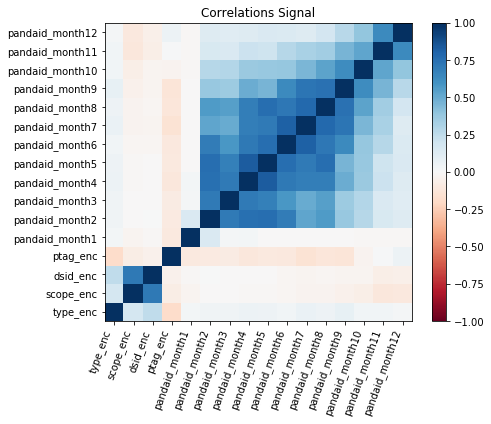

In [302]:
bg = XY.user_month13 < 0.5
sig = XY.user_month13 > 0.5

#for i in range(1, 13):
#    XY = XY.drop('user_month'+str(i), axis=1) #drop after adding
#    XY = XY.drop('site_month'+str(i), axis=1) #drop after adding

display(XY[bg].shape)
display(XY[sig].shape)

# remove the y column from the correlation matrix after using it to select background and signal
correlations(XY[bg].drop(['user_month13', 'pandaid_month13', 'site_month13'], 1), 'Background')
correlations(XY[sig].drop(['user_month13', 'pandaid_month13', 'site_month13'], 1), 'Signal')

#correlations(XY)

In [2]:
print('Hello')

Hello


In [3]:
for i in range(0, 10):
    print(str(i))

0
1
2
3
4
5
6
7
8
9
